In [1]:
import pandas as pd
import time
import seaborn
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import linear_model
import kernelml
import re

from ipyparallel import Client
rc = Client(profile='default')
dview = rc[:]

dview.block = True

with dview.sync_imports():
    #for some reason, aliases cannot be use
    import numpy
    import scipy

importing numpy on engine(s)
importing scipy on engine(s)


In [2]:
full = pd.read_csv('DATA/hb_training.csv')
test = pd.read_csv('DATA/hb_testing.csv')

def change_label(x):
    if x =='s':
        return 1
    else: 
        return 0
    
full['Label'] = full['Label'].apply(change_label)
EventId = test['EventId']
full.drop(['EventId'],axis=1,inplace=True)
test.drop(['EventId'],axis=1,inplace=True)
features = list(full.columns[:-2])
target = list(full.columns[-1:])

#randomly sample and split data
all_samples=full.index
ones = full[full[target].values==1].index
zeros = full[full[target].values==0].index
ones_rand_sample = np.random.choice(ones, size=int(len(ones)*0.5),replace=False)
zeros_rand_sample = np.random.choice(zeros, size=int(len(zeros)*0.5),replace=False)
rand_sample  = np.concatenate((ones_rand_sample,zeros_rand_sample))
np.random.shuffle(rand_sample)

test_sample = np.setdiff1d(all_samples,rand_sample)
valid = full.loc[test_sample,:]
train = full.loc[rand_sample,:]

In [3]:
class NNShapeHelper():

    def __init__(self,layer_shape,num_inputs,num_outputs):
        
        self.N_inputs = num_inputs
        self.N_outputs = num_outputs
        self.layer_shape = layer_shape
        self.N_layers = len(layer_shape)
        self.model_shape = []
        self.parameter_shape = []
        
    def get_N_parameters(self):
        
        self.model_shape.append(self.N_inputs)
        input_n_parameters = self.N_inputs*self.layer_shape[0]
        N =  input_n_parameters
        self.parameter_shape.append(input_n_parameters)
        
        for i in range(1,self.N_layers):
            layer_n_parameters = self.layer_shape[i-1]*self.layer_shape[i]
            self.model_shape.append(self.layer_shape[i])
            self.parameter_shape.append(layer_n_parameters)
            N += layer_n_parameters
            
        output_n_parameters = self.N_outputs*self.layer_shape[-1]
        N += output_n_parameters
        self.model_shape.append(self.N_outputs)
        self.parameter_shape.append(output_n_parameters)
        self.N_parameters = N
        return N

In [4]:
shapehelper = NNShapeHelper([10,len(features)],len(features),1)
num_parameters = shapehelper.get_N_parameters()
shapes = [shapehelper.model_shape,shapehelper.parameter_shape]
shapes

[[30, 30, 1], [300, 300, 30]]

In [5]:
def autoencoder_function(X,y,w_tensor,args,predict=False):
    #can't be passed to parallel engines, so I just assign the aliases manually
    #this is an improvement from loading the libraries again
    np = numpy
    stats = scipy.stats

    #arguement
    model_shape,parameter_shape,link = args
    
    # define the loss function between predicted output actual output
    def nn_autoencoder_loss(hypothesis,y):
        return np.sum((hypothesis-y)**2)/y.size

    #reshape parameter vector into list of matrices
    def reshape_vector(w):
        reshape_w = []
        indx = 0
        for shape,num in zip(model_shape,parameter_shape):
            x = w[indx:num+indx]
            if x.size!=num:
                continue
            x = x.reshape(shape,int(num/shape))
            reshape_w.append(x)
            indx = indx+num
        extra_w = w[indx:]
        return reshape_w,extra_w
        
    #Specifies the way the tensors are combined with the inputs
    def combine_tensors(X,w_tensor,link):
        w_tensor,extra_w = reshape_vector(w_tensor)
        b1,a1,b2,a2 = extra_w[:4]
        pred = X.dot(w_tensor[0])
        #choose link on encoding layer
        if link == 'linear':
            pred = a1*(pred+b1)
        elif link == 'field_eq':
            pred = -0.5*a1*pred + b1*pred
        elif link == 'log':
            pred = a1*pred + np.log(np.abs(pred)+b1)
        elif link == 'inverse':
            pred = a1/(pred+b1)

        pred = pred.dot(w_tensor[1].T)
        pred = a2*(pred+b2)
        return pred

    #we cannot modify pickled memory so create a copy of the parameter vector
    w_tensor_copy = w_tensor.copy()
    pred = combine_tensors(X,w_tensor_copy,link)
    if predict==True:
        return pred
    loss = nn_autoencoder_loss(pred,y)
    return loss

In [6]:
X = train[features].values
y = train[target].values

#customizable functions
"""
#prior parameter sampler (default)
def prior_sampler_uniform_distribution(weights,num_param):
    return np.random.uniform(low=-1,high=1,size=(num_param,1000))

#sampler function (default)
def sampler_multivariate_normal_distribution(best_param,
                                            param_by_iter,
                                            error_by_iter,
                                            parameter_update_history,
                                            random_sample_num=100):
    covariance = np.diag(np.var(parameter_update_history[:,:],axis=1))
    best = param_by_iter[np.where(error_by_iter==np.min(error_by_iter))[0]]
    mean = best.flatten()
    try:
        return np.random.multivariate_normal(mean, covariance, (random_sample_num)).T
    except:
        print(best,np.where(error_by_iter==np.min(error_by_iter)))

#intermediate sampler
def intermediate_uniform_distribution(weights,num_param):
    result = []
    for i in range(num_param):
        x = np.random.uniform(weights[i]-0.1*weights[i],weights[i]+0.1*weights[i],size=(1,10000)).T
        result.append(x)
    result = np.squeeze(np.array(result))
    return result          

#mini batch random choice sampler
def mini_batch_random_choice(X,y,batch_size):
    all_samples = np.arange(0,X.shape[0])
    rand_sample = np.random.choice(all_samples,size=batch_size,replace=False)
    X_batch = X[rand_sample]
    y_batch = y[rand_sample]
    return X_batch,y_batch
"""

#parameter transform
def positive_int_transform(w):
    out = w.copy()
    extra_w = out[-4:]
    for i in range(extra_w.shape[0]):
        extra_w[i][np.where(extra_w[i]<=0)[0]]=1e-6
    out[-4:] = extra_w
    return out.reshape(w.shape)

runs=20
zscore = 2.0
umagnitude = 0.00001
analyzenparam = 100
nupdates = 1
npriorsamples=3600
nrandomsamples = 2400
tinterations = 5
sequpdate = False
link = 'field_eq'

kml = kernelml.KernelML(
         prior_sampler_fcn=None,
         sampler_fcn=None,
         intermediate_sampler_fcn=None,
         mini_batch_sampler_fcn=None,
         parameter_transform_fcn=positive_int_transform,
         batch_size=500)

kml.use_ipyparallel(dview)

parameter_by_run = kml.optimize(X,X,loss_function=autoencoder_function,
                                num_param=num_parameters+4,
                                args=shapes+[link],
                                runs=runs,
                                total_iterations=tinterations,
                                analyze_n_parameters=analyzenparam,
                                n_parameter_updates=nupdates,
                                update_magnitude=umagnitude,
                                sequential_update=sequpdate,
                                percent_of_params_updated=0.8,
                                init_random_sample_num=npriorsamples,
                                random_sample_num=nrandomsamples,
                                prior_uniform_low=-1,
                                prior_uniform_high=1,
                                convergence_z_score=1,
                                plot_feedback=False,
                                print_feedback=False)

('run', 0, 'loss', 146578.7846361628, 'time', 6.362144947052002)
('run', 1, 'loss', 100267.14193227427, 'time', 7.634387969970703)
('run', 2, 'loss', 71972.952330770786, 'time', 8.16092300415039)
('run', 3, 'loss', 46520.481271872261, 'time', 7.096730947494507)
('run', 4, 'loss', 38567.515028045382, 'time', 6.658151865005493)
('run', 5, 'loss', 28465.667047696224, 'time', 6.325037956237793)
('run', 6, 'loss', 24851.040072695818, 'time', 6.671178817749023)
('run', 7, 'loss', 22961.177597452705, 'time', 6.472333192825317)
('run', 8, 'loss', 21961.548513005837, 'time', 6.156144857406616)
('run', 9, 'loss', 19469.94914574673, 'time', 5.742694139480591)
('run', 10, 'loss', 17366.664179343854, 'time', 6.129958868026733)
('run', 11, 'loss', 16774.069730162562, 'time', 5.93103289604187)
('run', 12, 'loss', 15290.275569158403, 'time', 5.985960960388184)
('run', 13, 'loss', 13245.139523151509, 'time', 5.983272075653076)
('run', 14, 'loss', 11214.182089741047, 'time', 6.55915093421936)
('run', 15

In [8]:
X = train[features].values
y = train[target].values
X_test = valid[features].values
y_test = valid[target].values

autoencoder_SST_train = np.sum((X - np.mean(X,axis=0))**2)/X.size
autoencoder_SST_test = np.sum((X_test - np.mean(X,axis=0))**2)/X_test.size

#get model parameters of last run by interation
kml.model.get_param_by_iter()
kml.model.get_loss_by_iter()

print('performance by run')
for i in range(parameter_by_run.shape[0]):
    w=parameter_by_run[i].copy()
    autoencoder_SSE_train = autoencoder_function(X,X,w,shapes+[link])
    autoencoder_SSE_test = autoencoder_function(X_test,X_test,w,shapes+[link])
    print('iteration',i,'train rsquared',1-autoencoder_SSE_train/autoencoder_SST_train,'test rsquared',1-autoencoder_SSE_test/autoencoder_SST_test)

performance by run
iteration 0 train rsquared -0.686450151062 test rsquared -0.687413466372
iteration 1 train rsquared -0.0987589664371 test rsquared -0.0975857943331
iteration 2 train rsquared 0.183253058222 test rsquared 0.188085793913
iteration 3 train rsquared 0.438715811101 test rsquared 0.44779741171
iteration 4 train rsquared 0.584866455489 test rsquared 0.587569810431
iteration 5 train rsquared 0.664658885385 test rsquared 0.665465830766
iteration 6 train rsquared 0.706943950828 test rsquared 0.708276719209
iteration 7 train rsquared 0.739134415297 test rsquared 0.739966841469
iteration 8 train rsquared 0.768029913131 test rsquared 0.768805215848
iteration 9 train rsquared 0.783132406225 test rsquared 0.783458553416
iteration 10 train rsquared 0.806548610964 test rsquared 0.806981511354
iteration 11 train rsquared 0.823871430485 test rsquared 0.824510841191
iteration 12 train rsquared 0.840289773893 test rsquared 0.840711257835
iteration 13 train rsquared 0.851690346057 test rs

In [9]:
X = train[features].values
y = train[target].values
X_test = valid[features].values
y_test = valid[target].values

autoencoder_SST_train = np.sum((X - np.mean(X,axis=0))**2)/X.size
autoencoder_SST_test = np.sum((X_test - np.mean(X,axis=0))**2)/X_test.size

def get_latent_encoding(X,w_tensor,link):
    w_tensor,extra_w = reshape_vector(w_tensor)
    b1,a1,b2,a2 = extra_w[:4]
    pred = X.dot(w_tensor[0])
    if link == 'linear':
        pred = a1*(pred+b1)
    elif link == 'field_eq':
        pred = -0.5*a1*pred + b1*pred
    elif link == 'log':
        pred = a1*np.log(np.abs(pred)+b1)
    elif link == 'inverse':
        pred = a1/(pred+b1)

    return pred

def reshape_vector(w):
    reshape_w = []
    indx = 0
    for shape,num in zip(shapes[0],shapes[1]):
        x = w[indx:num+indx]
        if x.size!=num:
            continue
        x = x.reshape(shape,int(num/shape))
        reshape_w.append(x)
        indx = indx+num
    extra_w = w[indx:]
    print('b1,a1,b2,a2',extra_w)
    return reshape_w,extra_w


#just for fun, we are going to use the latent variables in a predictive model
num_encodings = 5
encoding_dim = 10
X_prime = np.zeros((X.shape[0],num_encodings*encoding_dim))
X_test_prime = np.zeros((X_test.shape[0],num_encodings*encoding_dim))

#lets sample the last three iterations every 2 step (to avoid similarities)
start = 0
for i in np.arange(10,20,2):
    w=parameter_by_run[i].copy()
    X_prime[:,start:start+encoding_dim] = get_latent_encoding(X,w,link)
    X_test_prime[:,start:start+encoding_dim] = get_latent_encoding(X_test,w,link)
    start = start+encoding_dim

b1,a1,b2,a2 [ 0.03640615  0.11180976  0.03765359  0.17820258]
b1,a1,b2,a2 [ 0.03640615  0.11180976  0.03765359  0.17820258]
b1,a1,b2,a2 [ 0.0365186   0.10122866  0.3666661   0.20993291]
b1,a1,b2,a2 [ 0.0365186   0.10122866  0.3666661   0.20993291]
b1,a1,b2,a2 [  3.94071626e-02   1.04246803e-01   1.00000000e-06   2.07515293e-01]
b1,a1,b2,a2 [  3.94071626e-02   1.04246803e-01   1.00000000e-06   2.07515293e-01]
b1,a1,b2,a2 [ 0.0437813   0.11768894  0.04657603  0.16807767]
b1,a1,b2,a2 [ 0.0437813   0.11768894  0.04657603  0.16807767]
b1,a1,b2,a2 [ 0.04199653  0.11118947  2.53014692  0.17151564]
b1,a1,b2,a2 [ 0.04199653  0.11118947  2.53014692  0.17151564]


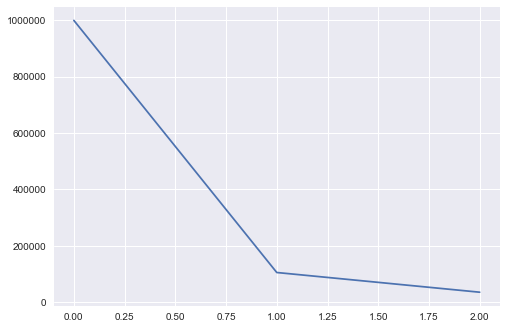

In [10]:
#lets combine the latent variables with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_prime)
    
plt.plot(pca.explained_variance_)
plt.show()

X_prime = pca.transform(X_prime)
X_test_prime = pca.transform(X_test_prime)

In [11]:
#add the original variables to the features set
X_prime = np.column_stack((X,X_prime))
X_test_prime = np.column_stack((X_test,X_test_prime))

In [12]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model, Sequential

def get_acc(predict,y):
    return np.sum((predict>0.5).astype(np.int)==y)/len(y)

Using TensorFlow backend.


In [13]:
#model with latent variable PCA components
input_data = Input(shape=(X_prime.shape[1],))
layer1 = Dense(200, activation='sigmoid')(input_data)
layer2 = Dense(1, activation='sigmoid')(layer1)
model = Model(input_data, layer2)

model.compile(optimizer='adagrad', 
                    loss='binary_crossentropy')
model.fit(X_prime, y,
                epochs=100,
                batch_size=5000,
                shuffle=False,
                validation_data=(X_test_prime, y_test))


Train on 124999 samples, validate on 125001 samples
Epoch 1/100
124999/124999 [==============================] - 1s 6us/step - loss: 0.5914 - val_loss: 0.5757
Epoch 2/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5642 - val_loss: 0.5559
Epoch 3/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5540 - val_loss: 0.5555
Epoch 4/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5422 - val_loss: 0.5354
Epoch 5/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5348 - val_loss: 0.5273
Epoch 6/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5238 - val_loss: 0.5204
Epoch 7/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5146 - val_loss: 0.5189
Epoch 8/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5045 - val_loss: 0.5003
Epoch 9/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.4994 - va

In [14]:
p_test = model.predict(X_test_prime)
p_train = model.predict(X_prime)
get_acc(p_test,y_test),get_acc(p_train,y)

(0.81968944248446007, 0.82370258962071696)

In [15]:
#model without latent variable PCA components
input_data = Input(shape=(X.shape[1],))
layer1 = Dense(200, activation='sigmoid')(input_data)
layer2 = Dense(1, activation='sigmoid')(layer1)
model = Model(input_data, layer2)

model.compile(optimizer='adagrad', 
                    loss='binary_crossentropy')
model.fit(X, y,
                epochs=100,
                batch_size=5000,
                shuffle=False,
                validation_data=(X_test, y_test))

Train on 124999 samples, validate on 125001 samples
Epoch 1/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5812 - val_loss: 0.5611
Epoch 2/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5593 - val_loss: 0.5587
Epoch 3/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5517 - val_loss: 0.5478
Epoch 4/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5480 - val_loss: 0.5486
Epoch 5/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5437 - val_loss: 0.5420
Epoch 6/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5404 - val_loss: 0.5393
Epoch 7/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5380 - val_loss: 0.5367
Epoch 8/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5351 - val_loss: 0.5340
Epoch 9/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5332 - va

In [16]:
p_test = model.predict(X_test)
p_train = model.predict(X)
get_acc(p_test,y_test),get_acc(p_train,y)

(0.80282557739538085, 0.80756646053168424)